<a href="https://colab.research.google.com/github/WaliMuhammadAhmad/T5-Abstract2Title/blob/main/Abstract2Title_T5_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 Model FineTuning #

T5 model is a pre-trained deep learning model that is based on the transformer-architecture. The T5's primary focus of application is in the field of Text-To-Text transformations i.e. Question-Answering, Translation, and Summarization.

Our main task in this notebook will be to create a fine-tuned model that will take in an abstract from a research article, and generate a title based on the input information.

**Dataset**

The dataset is provide in the repo is from kaggle. You can find this on kaggle from this link: https://www.kaggle.com/vetrirah/janatahack-independence-day-2020-ml-hackathon?select=train.csv


*Quoted from the kaggle description*:

**Topic Modeling for Research Articles
Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process. Given the abstract and title for a set of research articles, predict the topics for each article included in the test set.**

Even though the purpose of the dataset is to predict the topics of the articles, we will only be using it for the primary purpose of fine-tuning our pretrained T5 model to generate a title for each input abstract text.

In [1]:
!pip install transformers

In [2]:
train_data_loc = "/content/train.csv"
test_data_loc = "/content/test.csv"

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration
from torch.utils.data import random_split, RandomSampler
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch

**Hardware accelerator**

I will highly recommend you to use Hardware accelerator instead of using the default CPU the colab provides. If you have access to an A100 or V100 GPU, they will offer the best performance for fine-tunning large models like T5. If you're on a budget or have a more modest-sized model, the T4 GPU can be a reasonable choice. Another option is TPU, they can provide excellent performance for certain models and tasks. However, support for TPUs can be limited compared to GPUs. Not all libraries and models are fully compatible with TPUs. If you are using TPU then you may need to adjust your code and configuration.

If you have changed the runtime and have enablesd the hardware accelerator then there is a chance the the runtime enviroment would be reset, then re-run all of the cells above.

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
!nvidia-smi

Mon May 20 14:33:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
train_df = pd.read_csv(train_data_loc, encoding='utf-8')
test_df = pd.read_csv(test_data_loc, encoding='utf-8')

In [7]:
train_df.head()

,uuid,title,author,abstract,Keywords,label
0,0,Accessible Visual Artworks for Blind and Visua...,"Quero, Luis Cavazos; Bartolome, Jorge Iranzo; ...",Despite the use of tactile graphics and audio ...,accessibility technology; multimodal interacti...,0
1,1,Seizure Detection and Prediction by Parallel M...,"Li, Chenqi; Lammie, Corey; Dong, Xuening; Amir...","During the past two decades, epileptic seizure...",CNN; Seizure Detection; Seizure Prediction; EE...,1
2,2,Fast ScanNet: Fast and Dense Analysis of Multi...,"Lin, Huangjing; Chen, Hao; Graham, Simon; Dou,...",Lymph node metastasis is one of the most impor...,Histopathology image analysis; computational p...,1
3,3,Long-Term Effectiveness of Antiretroviral Ther...,"Huang, Peng; Tan, Jingguang; Ma, Wenzhe; Zheng...",In order to assess the effectiveness of the Ch...,HIV; ART; mortality; observational cohort stud...,0
4,4,Real-Time Facial Affective Computing on Mobile...,"Guo, Yuanyuan; Xia, Yifan; Wang, Jing; Yu, Hui...",Convolutional Neural Networks (CNNs) have beco...,facial affective computing; convolutional neur...,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['uuid'].plot(kind='hist', bins=20, title='uuid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('author').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('abstract').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Keywords').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='index', y='uuid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='uuid', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('title')):
  _plot_series(series, series_name, i)
  fig.legend(title='title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('author')):
  _plot_series(series, series_name, i)
  fig.legend(title='author', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('abstract')):
  _plot_series(series, series_name, i)
  fig.legend(title='abstract', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Keywords')):
  _plot_series(series, series_name, i)
  fig.legend(title='Keywords', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['uuid'].plot(kind='line', figsize=(8, 4), title='uuid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['author'].value_counts()
    for x_label, grp in _df_16.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('author')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['abstract'].value_counts()
    for x_label, grp in _df_17.groupby('author')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('author')
_ = plt.ylabel('abstract')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Keywords'].value_counts()
    for x_label, grp in _df_18.groupby('abstract')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('abstract')
_ = plt.ylabel('Keywords')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['author'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='author', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['abstract'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='index', y='abstract', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Keywords'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='index', y='Keywords', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [8]:
test_df.head()

,uuid,title,author,abstract
0,0,Tobacco Consumption and High-Sensitivity Cardi...,"Julia Brox Skranes,Magnus Nakrem Lyngbakken,Kr...",Background Cardiac troponins represent a sensi...
1,1,Approaching towards sustainable supply chain u...,"Mohammad Reza Seddigh,Sajjad Shokouhyar,Fateme...",These two main objectives of this study are to...
2,2,Does globalization matter for ecological footp...,"Kirikkaleli, Dervis; Adebayo, Tomiwa Sunday; K...",The main aim of this paper is to explore the r...
3,3,Myths and Misconceptions About University Stud...,"Megan Paull,Kirsten Holmes,Maryam Omari,Debbie...",This paper examines myths and misconceptions a...
4,4,Antioxidant Status of Rat Liver Mitochondria u...,"S I Khizrieva,R A Khalilov,A M Dzhafarova,V R ...",For evaluation of the contribution of the anti...


In [9]:
# Here we drop the columns that don't pertain to our task at hand

train_df.drop(columns=['uuid','author','Keywords','label'], inplace=True)

test_df.drop(columns=['uuid','author'], inplace=True)

The first thing I wanted to do was some exploratory data analysis. Primarily finding the distribution of word counts in all of our samples. The reason I do this is that due to memory constraints, the GPU may run out of memory.

In [10]:
# Descr: To display plots and metrics regarding token quantity in given input text
# Arguements:
# =====================================================================
# arr1 - input array 1
# arr2 - input array 2
# show_distr - whether to show plots of distributions
# return_distr - whether to return distribution arrays
# =====================================================================

def DisplayMaxTokens(arr1, arr2, show_distr = False, return_distr = False):
    arr1_maxlen = 0
    arr2_maxlen = 0

    seq1_LenArr = []
    seq2_LenArr = []

    for seq1, seq2 in zip(arr1, arr2):
        seq1_text = len(str(seq1).split())
        seq2_text = len(str(seq2).split())

        seq1_LenArr.append(seq1_text)
        seq2_LenArr.append(seq2_text)

        if(seq1_text > arr1_maxlen):
            arr1_maxlen = seq1_text
        if(seq2_text > arr2_maxlen):
            arr2_maxlen = seq2_text

    print("Maximum number of tokens in Array1: ", arr1_maxlen)
    print("Maximum number of tokens in Array2: ", arr2_maxlen)

    if(show_distr == True):
        sns.displot(seq1_LenArr);
        sns.displot(seq2_LenArr);

    if(return_distr == True):
        return seq1_LenArr, seq2_LenArr

Maximum number of tokens in Array1:  39
Maximum number of tokens in Array2:  685


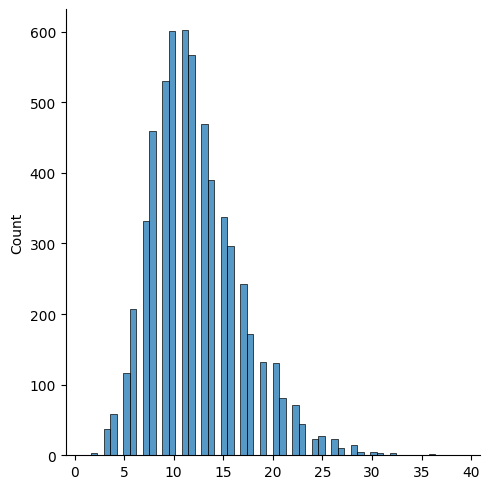

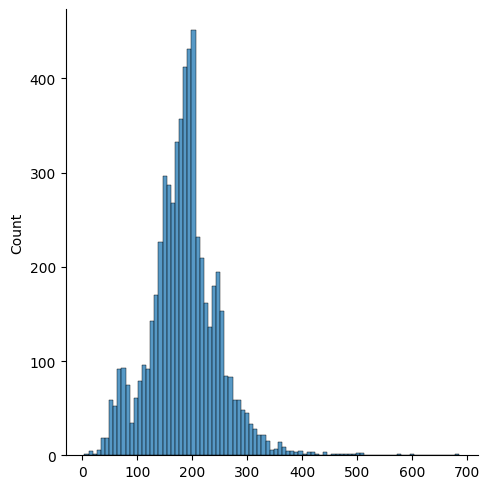

In [12]:
title_arr = train_df['title']
abstract_arr = train_df['abstract']

textlen_Arr, abstractlen_Arr = DisplayMaxTokens(title_arr, abstract_arr, show_distr=True, return_distr = True)

Here the abstract less then 200 words are removed for better experience

In [13]:
train_df['abs_len'] = abstractlen_Arr

train_df = train_df[train_df['abs_len'] <= 200]

In [14]:
title_arr = test_df['title']
abstract_arr = test_df['abstract']

textlen_Arr, abstractlen_Arr = DisplayMaxTokens(title_arr, abstract_arr, show_distr=False, return_distr = True)
test_df['abs_len'] = abstractlen_Arr

test_df = test_df[test_df['abs_len'] <= 200]

Maximum number of tokens in Array1:  37
Maximum number of tokens in Array2:  522


In [15]:
train_df.reset_index()
train_df.head()

,title,abstract,abs_len
0,Accessible Visual Artworks for Blind and Visua...,Despite the use of tactile graphics and audio ...,193
3,Long-Term Effectiveness of Antiretroviral Ther...,In order to assess the effectiveness of the Ch...,199
4,Real-Time Facial Affective Computing on Mobile...,Convolutional Neural Networks (CNNs) have beco...,160
6,ROS System Facial Emotion Detection Using Mach...,Facial emotion recognition (FER) is a field of...,196
8,Universal blind image quality assessment using...,Most current state-of-the-art blind image qual...,155


In [16]:
test_df.reset_index()
test_df.head()

,title,abstract,abs_len
2,Does globalization matter for ecological footp...,The main aim of this paper is to explore the r...,156
3,Myths and Misconceptions About University Stud...,This paper examines myths and misconceptions a...,149
4,Antioxidant Status of Rat Liver Mitochondria u...,For evaluation of the contribution of the anti...,119
9,Serum GDF-15 Predicts In-Hospital Mortality an...,This study aims to evaluate the association of...,191
12,Modelling environmental degradation in South A...,This study investigates the effects of energy ...,178


In [17]:
# Descr: Dataset class which is used to load our training data
# Constructor Arguements:
# =====================================================================
# title_arr - Array of article titles
# abstract_arr - Array of article abstracts
# tokenizer - Input tokenizer used to tokenize our text
# =====================================================================

class ResearchDataset(Dataset):
    def __init__(self, title_arr, abstract_arr, tokenizer):
        self.title_arr = title_arr
        self.abstract_arr = abstract_arr
        self.tokenizer = tokenizer

        def ArrayLength():
            title_arr_length = len(self.title_arr)
            if(title_arr_length == len(self.abstract_arr)):
                return title_arr_length
            else:
                raise Exception("Array Lengths not Equal!!!")

        self.arr_len = ArrayLength()

    def __len__(self):
        return self.arr_len

    def __getitem__(self, index):
        title = self.title_arr[index]
        abstract = self.abstract_arr[index]

        input_ = abstract + " </s>"
        output_ = title + " </s>"

        #Encoding our inputs
        inputs = self.tokenizer.encode_plus(input_, pad_to_max_length=True,return_attention_mask=True, max_length=201)
        #Encoding our outputs
        outputs = self.tokenizer.encode_plus(output_, pad_to_max_length=True,return_attention_mask=True, max_length=41)

        input_ids = inputs['input_ids']
        input_attention_masks = inputs['attention_mask']

        output_ids = outputs['input_ids']
        output_attention_masks = outputs['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'input_mask': torch.tensor(input_attention_masks, dtype=torch.long),
            'output_ids': torch.tensor(output_ids, dtype=torch.long),
            'output_mask': torch.tensor(output_attention_masks, dtype=torch.long)
        }

**SentencePiece Error**

If the cell below throw an exception of SentencePiece then run this cell to install its latest version. It happens usually. After installing SentencePiece, restart your runtime and you are good to go!

In [18]:
!pip install SentencePiece

In [19]:
# Loading pre-trained T5-base Tokenizer of T5-base Model

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [20]:
# Performing splitting of our Dataset in train and validation. Because we were already provided a Validation Dataset,
# we will not be splitting our train set here, hence our trainset_ratio = 1.0

research_dataset = ResearchDataset(title_arr, abstract_arr,tokenizer)

trainset_ratio = 1.0

data_len = len(research_dataset)
print("Total Data Size: ", data_len)

training_data_size = int(data_len*trainset_ratio)
print("Training Data Size: ", training_data_size)

val_data_size = data_len - training_data_size
print("Validation Data Size: ", val_data_size)

train_dataset, validation_dataset = random_split(research_dataset, [training_data_size, val_data_size])

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size=batch_size)

if(trainset_ratio != 1.0):
    validation_dataloader = DataLoader(validation_dataset, sampler = RandomSampler(validation_dataset), batch_size=batch_size)

Total Data Size:  2000
Training Data Size:  2000
Validation Data Size:  0


In [21]:
# Our actual Process of fine-tuning is done here

LEARNING_RATE = 1e-05

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

epochs = 1
steps2report = 500

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

for epoch in range(0,epochs):
    model.train()
    for step, data in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Getting input parameters
        x_input_ids = data['input_ids'].to(device)
        x_masks = data['input_mask'].to(device)

        # Getting output parameters
        y_expl_ids = data['output_ids'].to(device)

        # Feeding values into our model
        outputs = model(input_ids              = x_input_ids,
                        attention_mask         = x_masks,
                        labels                 = y_expl_ids)
        loss = outputs[0]

        if step%steps2report==0:
            print("EPOCH: ", epoch, " loss.item: ", loss.item())

        loss.backward()
        optimizer.step()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning:

EPOCH:  0  loss.item:  9.817386627197266


## **Download the model Locally**

If you want to download the model locally on your machine then run the 5 cells below, these cells will let you to download the exported folder's zipfile locally on your machine and also let you to save the zipfile on your google drive accout.

In [23]:
model_repository = "/content/"
model_name = "FineTuned_T5_Title_Abstract"

model.save_pretrained(model_repository+model_name)

In [29]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained("/content/FineTuned_T5_Title_Abstract");
model.to(device);

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Run the cell below to create a zip file of the exported folder

In [31]:
import zipfile
import os

folder_path = "/content/FineTuned_T5_Title_Abstract"
output_zip_path = "/content/Abstract2Title_T5_model"

if os.path.exists(output_zip_path):
    raise FileExistsError("The specified output path already exists as a directory. Please provide a output path for the zip file.")
else:
    # Create a zip file
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))


Run the cell below to mount your drive account **if you have not mounted**

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This cell moves the resulting zip file to your Google Drive. You can access it in Google Drive and download it to your local machine from there as well.

In [34]:
import shutil

shutil.move("/content/Abstract2Title_T5_model", "/content/drive/MyDrive/Colab Notebooks/")

'/content/drive/MyDrive/Colab Notebooks/Abstract2Title_T5_model'

### Validation ###

Now that the process of fine-tuning is over, we can now get to the process of validation. We start out by pre-processing our test dataframes and creating our Test-ResearchDataSet and Test-DataLoader. After this we then go through our validation loop where we generate a prediction from each input_id and input_mask, we then store that prediction in model_outputArr, and the expected predictions in target_outputArr.

In [35]:
title_arr = test_df['title']
abstract_arr = test_df['abstract']

title_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', title) for title in title_arr]
abstract_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', abstract) for abstract in abstract_arr]

batch_size = 32
testresearch_dataset = ResearchDataset(title_arr, abstract_arr, tokenizer)
test_dataloader = DataLoader(testresearch_dataset, sampler = RandomSampler(testresearch_dataset), batch_size=batch_size)

In [36]:
import torch
model.eval()

model_inputArr = []
model_outputArr = []
target_outputArr = []

with torch.no_grad():
    for step, data in enumerate(test_dataloader):
        input_ids = data["input_ids"].to(device)
        input_masks = data["input_mask"].to(device)
        explanation_ids = data["output_ids"].to(device)
        explanation_masks = data["output_mask"].to(device)
        output = model.generate(input_ids = input_ids, attention_mask = input_masks, max_length=200,do_sample=False )

        for input_vector, output_vector in zip(input_ids, output):
            model_inputArr.append(tokenizer.decode(input_vector, skip_special_tokens=True))
            model_outputArr.append(tokenizer.decode(output_vector, skip_special_tokens=True))
        target_outputArr.append(tokenizer.batch_decode(explanation_ids, skip_special_tokens=True))

target_outputArr = [item for sublist in target_outputArr for item in sublist]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning:

In [37]:
# Creating a new dataframe that contains our input, model predicted outout, and expected target output

data_ = {
    'input' : model_inputArr,
    'model output' : model_outputArr,
    'target output' : target_outputArr
}
results_dataframe = pd.DataFrame(data = data_)

In [38]:
results_dataframe.head()

,input,model output,target output
0,Recently companies in emerging markets have im...,apply structural equation modeling method to t...,Behavioral and technical perspectives of green...
1,The molecular structure and solutionstate mole...,The molecular structure and solutionstate mole...,Fourier Transform Infrared Spectroscopy and Vi...
2,Many countries and regions consider industrial...,a new industrialized construction method OSI O...,A new framework of industrialized construction...
3,In recent years the impacts of biomass energy ...,This study aims to investigate the effects of ...,Biomass energy production and its impacts on t...
4,Induction of labour IoL is generally conducted...,induction of labour of pregnancy and postterm ...,Optimal timing of labour induction in contempo...


### BLEU Evaluation ###

Now that we have our predictions, we can evaluate the quality of our predictions based on the Bi-Lingual Evaluation Understudy(BLEU). In brief, we compare our generated sentences with our target sentences by counting the matching n-grams. In layman's terms, how well individual segment texts match from our predicted text to the expected text.

In [39]:
bleu_scores = []

for model_output, target_output in zip(model_outputArr, target_outputArr):
    model_token_arr = model_output.split();
    target_token_arr = model_output.split();

    score = sentence_bleu([target_token_arr], model_token_arr)

    bleu_scores.append(score)

print("Average Bleu Score: ", np.mean(bleu_scores))

Average Bleu Score:  0.9913513513513513
